In [164]:
from pathlib import Path
import os

import equinox as eqx
from fire import Fire
import jax
import jax.numpy as jnp
import jax.random as jrandom
from matplotlib import pyplot as plt
import tqdm

from neuralodes.data.dataloader import get_dataloaders
from neuralodes.model.oderesnet.evaluation import evaluate
from neuralodes.model.oderesnet.odenet import ODENet, ODENetEulerWrapper
from neuralodes.model.oderesnet.resnet import ResNet

In [3]:
if Path(os.getcwd()).name == "notebooks":
    os.chdir(Path(os.getcwd()).parent)

In [41]:
loaded_solver_name = 'Tsit5'
key = jrandom.PRNGKey(0)
model_solver_name = "tsit5"

print("Loading models...")
odenet = eqx.tree_deserialise_leaves(Path("models", "oderesnet", f"odenet_fashionmnist_{loaded_solver_name}_64.eqx"), ODENet(key, model_solver_name))
resnet = eqx.tree_deserialise_leaves(Path("models", "oderesnet", f"resnet_fashionmnist_Tsit5_64.eqx"), ResNet(key))

_, test_dataloader = get_dataloaders("fashionmnist", 256)

downsampler = odenet.layers[0]
ode_func = odenet.layers[1].odefunc


Loading models...


In [84]:
x_tensor,y_tensor = next(iter(test_dataloader))
x_arr = x_tensor.numpy()
y_arr = y_tensor.numpy()

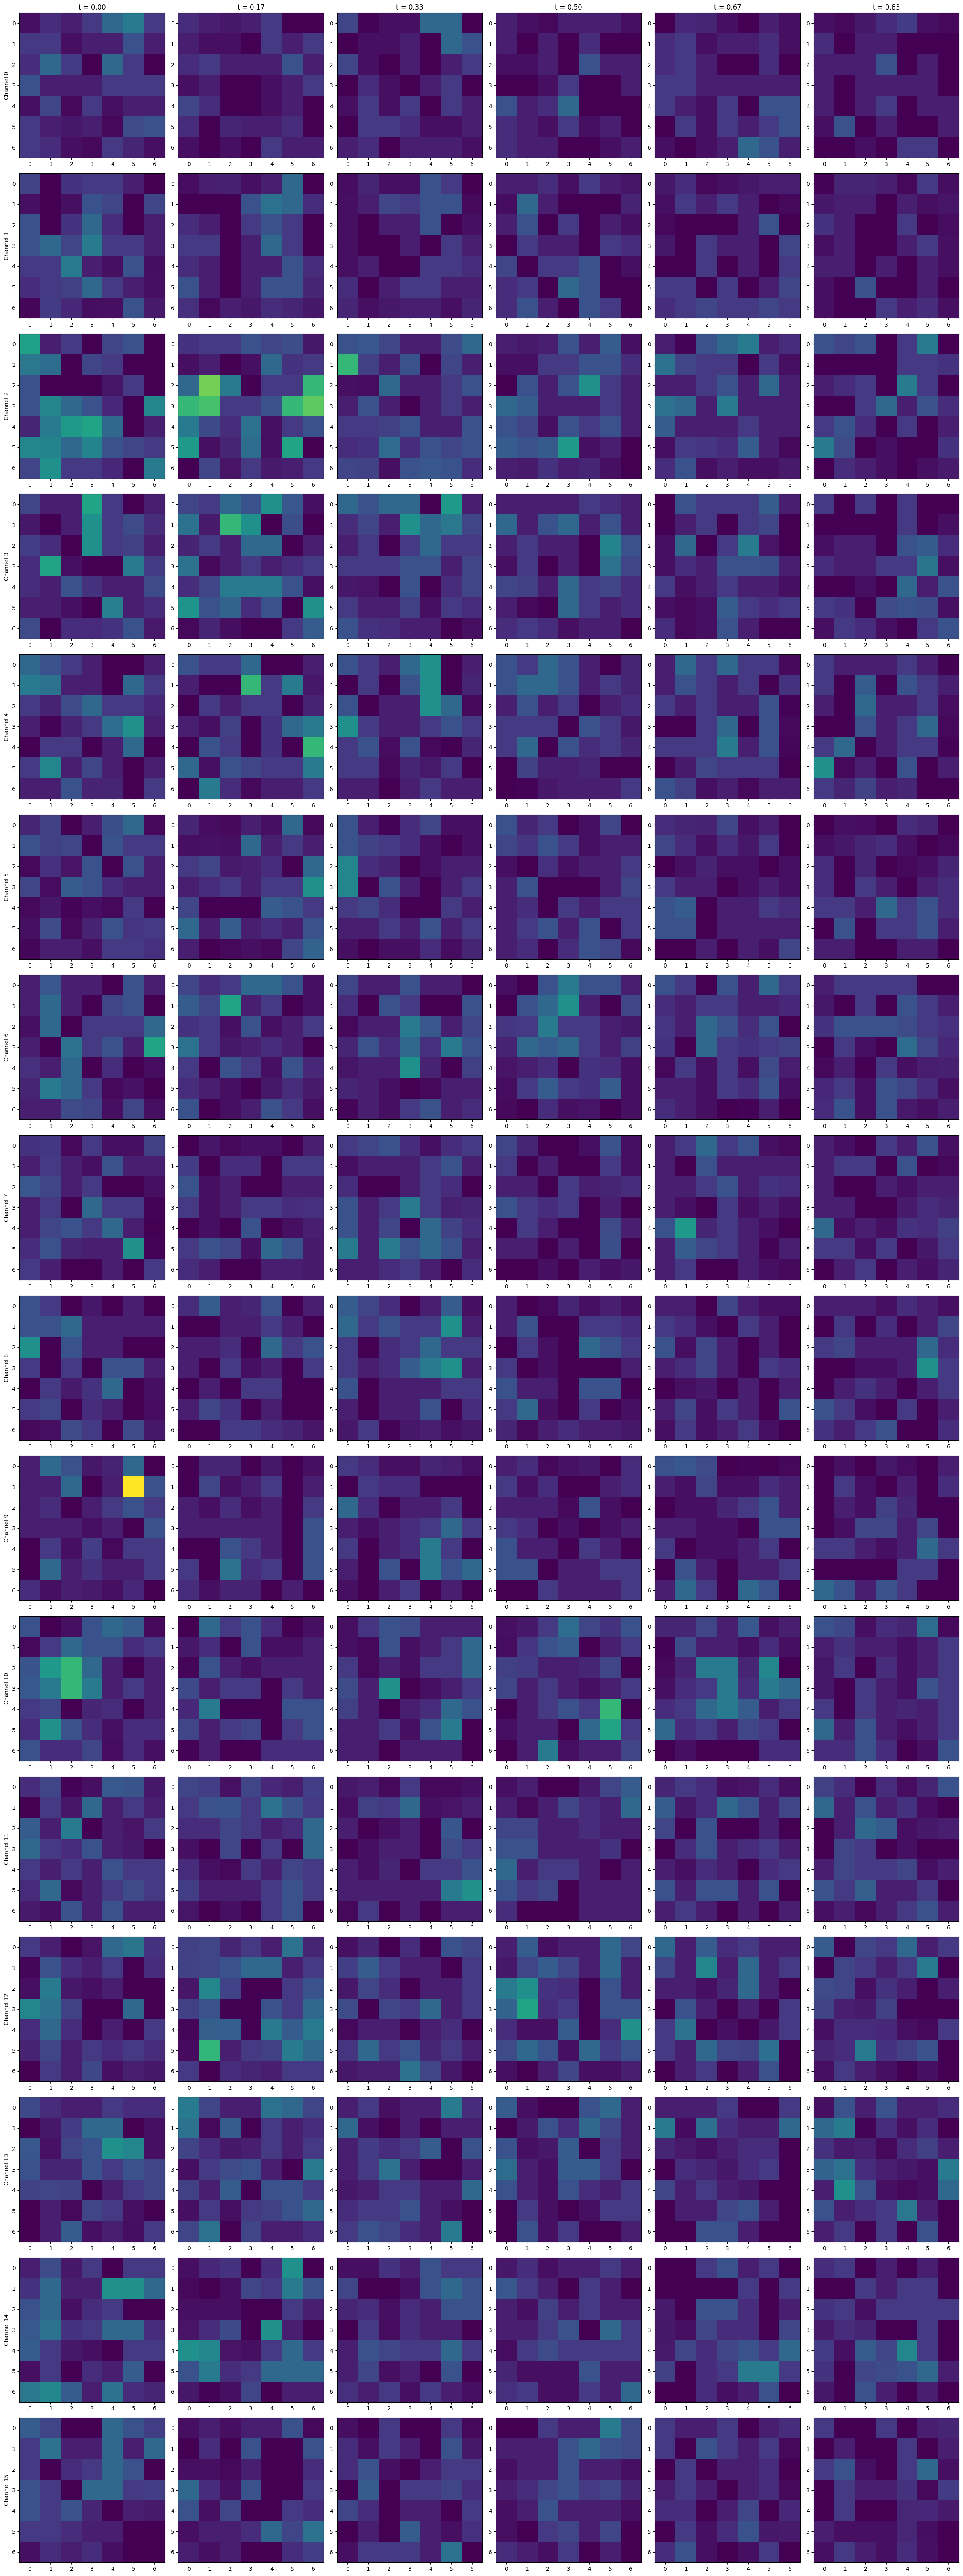

In [171]:
# Generate input data (x) with appropriate shape
# Assuming input has shape (batch_size, dim, height, width)
height, width = 7, 7
x_raw = x_arr[0]
x = downsampler(x_raw)

# Define values of t for which you want to visualize activations
t_values_to_show = 6
t_values = [x/t_values_to_show for x in list(range(6))]
dt = t_values[1] - t_values[0]

# Define a function to visualize the activations
def visualize_sensitivity_multi_channel(sensitivity, t_values, channels_to_show):
    num_t_values = len(t_values)
    num_channels = len(channels_to_show)

    fig, axes = plt.subplots(num_channels, num_t_values, figsize=(4 * num_t_values, 4 * num_channels))
    vmin = jnp.min(sensitivity)
    vmax = jnp.max(sensitivity)
    
    for i, t in enumerate(t_values):
        for j, channel in enumerate(channels_to_show):
            ax = axes[j, i]
            ax.imshow(sensitivity[i, channel], cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
            if j == 0:
                ax.set_title(f't = {t:.2f}')
            if i == 0:
                ax.set_ylabel(f'Channel {channel}')
    plt.tight_layout()
    plt.savefig("test.png")
    plt.show()
    
# Generate a small perturbation to the input data (x)
epsilon = 1e-2
perturbation = epsilon #* jrandom.normal(key, x.shape)

# Update the channels_to_show variable
channels_to_show = list(range(0, 16))

# Compute the output for the original and perturbed inputs for the selected channels
outputs = []
outputs_perturbed = []

for t in t_values:
    x_perturbed = x + perturbation
    output = ode_func(t, x, None)
    output_perturbed = ode_func(t, x_perturbed, None)
    outputs.append(jnp.stack([output[channel] for channel in channels_to_show]))
    outputs_perturbed.append(jnp.stack([output_perturbed[channel] for channel in channels_to_show]))
    x = x + output*dt

outputs = jnp.stack(outputs)
outputs_perturbed = jnp.stack(outputs_perturbed)

# Calculate the difference between the outputs for the selected channels
sensitivity = jnp.abs(outputs_perturbed - outputs)

# Visualize the sensitivity for the selected channels
visualize_sensitivity_multi_channel(sensitivity, t_values, channels_to_show)